<a href="https://colab.research.google.com/github/tluxxx/ModernPortfolioTheory/blob/main/portfolio_theory_basics_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Theory Basics -- Part 2

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('dark_background')

import yfinance as yf
from tqdm import tqdm
from scipy.optimize import minimize

In [2]:
class Portfolio:
    ''' Represents a portfolio of assets and provides methods for analysis and visualization.

    Parameters:
        rets (pd.DataFrame): DataFrame of asset returns, where columns are tickers and rows are time periods.
        risk_free_rate (float): annual risk free rate.

    Attributes:
        rets (pd.DataFrame): The input returns DataFrame.
        tickers (pd.Index): The tickers of the assets in the portfolio (extracted from column names of `rets`).
        num_assets (int): The number of assets in the portfolio.
        mean_returns (pd.Series): The mean returns of each asset.
        cov_matrix (pd.DataFrame): The covariance matrix of the asset returns.

    Methods:
        simulate_portfolios(num_portfolios=10000): Simulates random portfolios and calculates their returns, risks, and Sharpe ratios.
        plot_portfolios(results, weights_record): Plots the simulated portfolios in a risk-return diagram with Sharpe ratio as color code.
        plot_constituents(): Plots the individual constituents of the portfolio in a risk-return diagram.
        plot_all(): Combines the portfolio and constituent plots into one diagram.
    '''

    # Code Blocks of inititalisation and general helper functions

    def __init__(self, returns, risk_free_rate):
        self.rets = returns
        self.rfr = risk_free_rate               # annual risk free rate
        self.tickers = returns.columns          # get tickers from column names
        self.num_assets = len(self.tickers)     # get number of tickers
        self.mean_rets = returns.mean()         # get mean returns for each ticker
        self.standard_devs = returns.std()      # get standard deviations for each ticker
        self.cov_matrix = returns.cov()         # get covariance matrix for all tickers

    def portfolio_std(self, weights):
        ''' Calculate the standard deviation of a portfolio given the weights of the portfolio members'''
        return np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))

    def neg_sharpe_ratio(self, weights):
        ''' Calculates the negative Sharpe ratio of a portfolio given the weights of the portfolio members'''
        pf_return = np.sum(self.mean_rets * weights) * 252      # return of a weighted portfolio
        pf_std = self.portfolio_std(weights) * np.sqrt(252)     # standard deviation of a weighted portfolio
        return - (pf_return - self.rfr) / pf_std                # negative value of sharp ratio (for minimizing)

    def neg_cml_slope(self, weights):
        ''' calculates the maximum negative slope of the CML, given the weights of the portfolio members'''
        pf_return = np.sum(self.mean_rets * weights) * 252      # returns of a weighted portfolio
        pf_std = self.portfolio_std(weights) * np.sqrt(252)     # standard deviation of a weighted portfolio
        return - (pf_return - self.rfr) / pf_std                # negative value of the CML-slope (for minimizing)


    # Code Blocks of calculation methods within the Portfolio Class

    def simulate_portfolios(self, num_portfolios=50000):
        ''' Simulate a large number of randomly weighted  portfolios of given constituents
            and calculate their returns, risks, and sharpe ratios.'''

        results = np.zeros((3, num_portfolios)) # initialize results
        weights_record = []                     # initialise record of simulated weights

        for i in tqdm(range(num_portfolios)):
            # generation, normalizing and storing random weights
            #weights = np.random.random(self.num_assets)
            #weights /= np.sum(weights)
            weights = np.random.dirichlet(np.ones(self.num_assets), size=1)[0]
            weights_record.append(weights)

            # calculation of portfolio parameters for random weights and storing the results
            pf_return = np.sum(self.mean_rets * weights) * 252
            pf_std = self.portfolio_std(weights) * np.sqrt(252)

            results[0, i] = pf_return                               # annualized portfolio return
            results[1, i] = pf_std                                  # annualized portfolio risk (standard deviation)
            results[2, i] = (pf_return - self.rfr) / pf_std         # effective sharpe ratio of portfolio (- risk free rate)
        return results, weights_record

    def efficient_frontier(self):
        ''' Calculate the efficient frontier for the portfolio.'''

        # initalizing
        self.st_devs = []
        weights = []
        valid_target_rets = []

        # finding the relevant interval of returns and interationg trough it
        self.target_rets = np.linspace(self.mean_rets.min(), self.mean_rets.max(), 300)

        for target_ret in self.target_rets:
            # definition of boundary conditions and constraints
            constraints = [
                {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                {'type': 'eq', 'fun': lambda w: np.dot(w, self.mean_rets) - target_ret}
            ]
            bounds = [(0, 1) for _ in range(self.num_assets)]

            # initiatlisation of weights
            w0 = np.ones(self.num_assets) / self.num_assets

            # calculation of sigma, corresponding to a target return
            result = minimize(lambda w: self.portfolio_std(w), w0,
                              constraints=constraints, bounds=bounds, method='SLSQP')

            # in case of sucessfully finalized calculation
            if result.success:
                weights.append(result.x)
                self.st_devs.append(self.portfolio_std(result.x))
                valid_target_rets.append(target_ret)

            # error log in case of unsecessfully terminated calculation
            else:
                print(f'optimisation for target return {target_ret*252:.5f} failed, calculation terminated')

        return np.array(self.st_devs), np.array(valid_target_rets), weights

    def min_risk_portfolio(self):
        ''' Finds the portfolio with minimal risk (= min. standard deviation)'''

        # definition of boundary conditions and constraints
        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
        bounds = [(0, 1) for _ in range(self.num_assets)]

        # initialisation of weights
        w0 = np.ones(self.num_assets) / self.num_assets  # Initial weights (equal allocation)

        # caclulation of minimum risk portfolio
        result = minimize(self.portfolio_std, w0, constraints=constraints, bounds=bounds, method='SLSQP')

        # in case of sucessfully finalized calculation
        if result.success:
            min_risk_weights = result.x
            min_risk = self.portfolio_std(min_risk_weights) * np.sqrt(252)          # annualized risk of min-risk protfolio
            min_risk_return = np.sum(self.mean_rets * min_risk_weights) * 252       # annualized return of min-risk portfolio
            min_risk_sharpe = (min_risk_return - self.rfr) / min_risk               # sharpe ratio of min-risk portfolio
            return min_risk, min_risk_return, min_risk_sharpe, min_risk_weights

        # error log in case of unsecessfully terminated calculation
        else:
            print('calculation for Minimum Risk Portfolio failed, calculation terminated')

    def max_sharpe_portfolio(self):
        ''' Finds the portfolio with the maximum Sharpe ratio. '''

        # boundary conditions and constraints
        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
        bounds = [(0, 1) for _ in range(self.num_assets)]

        # initialization of weights
        w0 = np.ones(self.num_assets) / self.num_assets  # Initial weights (equal allocation)

        # calculation of maximum sharpe ratio portfolio
        result = minimize(self.neg_sharpe_ratio, w0, constraints=constraints, bounds=bounds, method='SLSQP')

        # in case of sucessfully finalized calculation
        if result.success:
            max_sharpe_weights = result.x
            max_sharpe_return = np.sum(self.mean_rets * max_sharpe_weights) * 252           # annualized return of max-sharpe portfolio
            max_sharpe_risk = self.portfolio_std(max_sharpe_weights) * np.sqrt(252)         # annualized risk of max-sharpe portfolio
            max_sharpe_ratio = (max_sharpe_return - self.rfr) / max_sharpe_risk             # sharpe ratio of max-sharpe portfolio
            return max_sharpe_risk, max_sharpe_return, max_sharpe_ratio, max_sharpe_weights

        # error log in case of unsecessfully terminated calculation
        else:
            print('calculation for Maximum Sharpe Portfolio failed, calculation terminated')

    def market_portfolio_and_cml(self):
        '''Calculates and plots the market portfolio and the Capital Market Line (CML).'''

        # boundary conditions and constraints
        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
        bounds = [(0, 1) for _ in range(self.num_assets)]

        # initialisation of weights
        w0 = np.ones(self.num_assets) / self.num_assets

        # calculation of market portfolio by maximizing CML slope
        result = minimize(self.neg_cml_slope, w0, constraints=constraints, bounds=bounds, method='SLSQP')

        # in case of sucessfully finalized calculation
        if result.success:
            market_portfolio_weights = result.x
            market_portfolio_return = np.sum(self.mean_rets * market_portfolio_weights) * 252       # annualized returns of market portfolio
            market_portfolio_std = self.portfolio_std(market_portfolio_weights) * np.sqrt(252)      # annualized risk of market portfolio
            market_portfolio_sharpe = (market_portfolio_return - self.rfr) / market_portfolio_std   # sharpe of market portfolio
            return market_portfolio_std, market_portfolio_return, market_portfolio_sharpe, market_portfolio_weights

        # error log in case of unsecessfully terminated calculation
        else:
            print('calculation for Market Portfolio failed, calculation terminated')


    # Code blocks for plotting the results

    def plot_efficient_frontier(self):
        ''' Plot the efficient frontier of the portfolio and some special portfolios '''

        # caclulate and plot effiecent frontier
        eff_devs, eff_rets, eff_weights = self.efficient_frontier()
        plt.plot(eff_devs * np.sqrt(252), eff_rets * 252, label="Efficient Frontier", color="blue", linewidth=2)

        # Calculate and plot the minimum risk portfolio:
        self.min_risk, self.min_risk_return, self.min_risk_sharpe, self.min_risk_weights = self.min_risk_portfolio()
        plt.scatter(self.min_risk, self.min_risk_return, color='green', marker='*', s=200, label="Minimum Risk Portfolio", zorder=3)
        plt.legend()

        # Calculate and plot the maximum Sharpe ratio portfolio:
        self.max_sharpe_risk, self.max_sharpe_return, self.max_sharpe_ratio, self.max_sharpe_weights  = self.max_sharpe_portfolio()
        plt.scatter(self.max_sharpe_risk, self.max_sharpe_return, color='yellow', marker='*', s=200, label="Maximum Sharpe Portfolio", zorder=3)
        plt.legend()

        # --- Get market portfolio and CML data from market_portfolio_and_cml ---
        self.market_std, self.market_return, self.market_sharpe, self.market_weights = self.market_portfolio_and_cml()

        # Plot the market portfolio with a star marker
        plt.scatter(self.market_std, self.market_return, color='purple', marker='*', s=200, label="Market Portfolio", zorder=4)

        # Plot the Capital Market Line (CML)
        x_cml = np.linspace(0, self.market_std * 1.1, 100)  # Extend CML slightly beyond market portfolio
        y_cml = self.rfr + (self.market_return - self.rfr) / self.market_std * x_cml
        plt.plot(x_cml, y_cml, color='magenta', linestyle='--', label="Capital Market Line (CML)", zorder=2)
        plt.legend()

    def plot_portfolios(self, results, weights_record):
        ''' plotting thre simulated protfolios'''
        plt.figure(figsize=(10, 6))
        plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis_r', alpha=0.8, s=5, marker='o')
        plt.colorbar(label='Sharpe Ratio')

    def plot_constituents(self):
        ''' plotting the portfolio members '''
        my = self.mean_rets * 252
        sig = self.standard_devs * np.sqrt(252)
        plt.scatter(sig, my, color='red', marker='o', s=50)
        for i, ticker in enumerate(self.tickers):
            plt.annotate(ticker, (sig.iloc[i] , my.iloc[i]),
                         textcoords="offset points", xytext=(0, 10), ha='center', color='red')

    # Code Block for printing key data

    def data_constituents(self):
        ''' tabulating key data in a dataframe'''
        # sharpe without and with considering risk free return
        self.sharpe1 = self.mean_rets / self.standard_devs * np.sqrt(252)
        self.sharpe2 = (self.mean_rets  * 252 - self.rfr) / (self.standard_devs * np.sqrt(252))
        print('\n ** key data portfolio members **')
        res1 = {'Tickers': self.tickers,
                'Returns': self.mean_rets * 252,
                'Risk': self.standard_devs * np.sqrt(252),
                'Sharpe (Orig.)': self.sharpe1,
                'Sharpe (incl. rfr)': self.sharpe2
                }
        res1 = pd.DataFrame(res1)
        res1.set_index('Tickers', inplace=True)
        return res1


    def data_portfolios(self):
        ''' tabulating key data in a dataframe'''
        print('\n ** key data special portfolios **')

        res2 = {'Type':['Minimum Risk Portfolio', 'Maximum Sharpe Portfolio'],
                'Risk': [self.min_risk, self.max_sharpe_risk],
                'Return': [self.min_risk_return, self.max_sharpe_return],
                'Sharpe': [self.min_risk_sharpe, self.max_sharpe_ratio],
                'Composition': [np.round(self.min_risk_weights, decimals=3),
                                np.round(self.max_sharpe_weights, decimals=3)]
                }
        res = pd.DataFrame(res2)
        res.set_index('Type', inplace=True)
        return res

## Experiment 1: Portfolio with 3 members

In [ ]:
# downloading real stock-data
tickers = ['SAP.DE', 'DHL.DE', 'IFX.DE']
data = yf.download(tickers, start='2020-01-01', end='2024-12-31')['Close']
all_rets = data.pct_change(fill_method=None).dropna()


In [ ]:
print('statistic parameters for daily returns')
for col in all_rets.columns:
    mean = all_rets[col].mean()
    std = all_rets[col].std()
    print(f"ticker: {col}, mean: {mean:.5f}, standard deviation: {std:.5f}")

statistic parameters for daily returns
ticker: DHL.DE, mean: 0.00017, standard deviation: 0.01833
ticker: IFX.DE, mean: 0.00071, standard deviation: 0.02554
ticker: SAP.DE, mean: 0.00077, standard deviation: 0.01705


In [ ]:
# generate instance of portfolio-class
risk_free_rate = 0.03
ptf = Portfolio(all_rets, risk_free_rate)

In [ ]:
# simulating of portfolios
simulations, weights_record = ptf.simulate_portfolios(num_portfolios=50000)

100%|██████████| 50000/50000 [00:13<00:00, 3623.79it/s]


<Figure size 600x400 with 0 Axes>

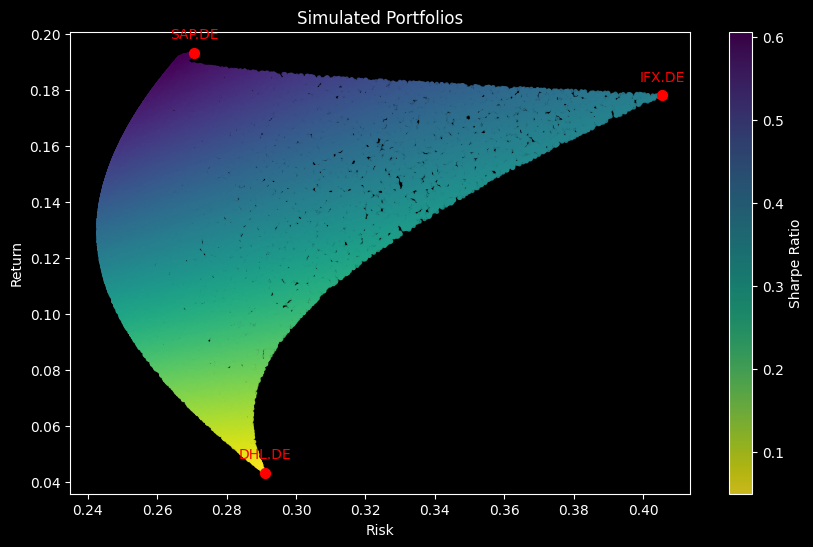

In [ ]:
# plotting of simulated portfolios and of portfolio members
plt.figure(figsize=(6, 4));
ptf.plot_portfolios(simulations, weights_record)    # Plot simulated portfolios
ptf.plot_constituents()                             # Plot constituents on the same figure

plt.xlabel('Risk')
plt.ylabel('Return')
plt.title('Simulated Portfolios')
plt.show()

<Figure size 600x400 with 0 Axes>

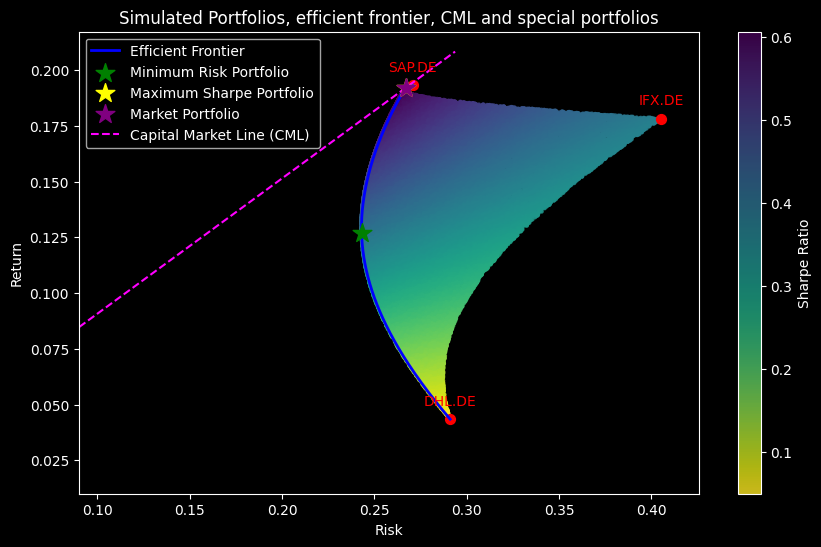

In [ ]:
# plotting of simulated portfolios/portfolio members, efficient frontier and special portfolios
plt.figure(figsize=(6, 4));
ptf.plot_portfolios(simulations, weights_record)    # Plot simulated portfolios
ptf.plot_constituents()                             # Plot constituents on the same figure
ptf.plot_efficient_frontier()                       # plot efficient frontier and special portfolios

# plotting
plt.xlabel('Risk')
plt.ylabel('Return')
plt.title('Simulated Portfolios, efficient frontier, CML and special portfolios')
plt.xlim(0.09)
plt.ylim(0.01)
plt.show()

In [ ]:
# printing paramters of members
df_res1 = ptf.data_constituents()
df_res1


 ** key data portfolio members **


,Returns,Risk,Sharpe (Orig.),Sharpe (incl. rfr)
Tickers,,,,
DHL.DE,0.043421,0.291055,0.149185,0.046112
IFX.DE,0.178281,0.405386,0.439781,0.365777
SAP.DE,0.193358,0.270729,0.714214,0.603402


In [ ]:
# printing parameters of special portfolios
dfy = ptf.data_portfolios()
dfy


 ** key data special portfolios **


,Risk,Return,Sharpe,Composition
Type,,,,
Minimum Risk Portfolio,0.243112,0.126917,0.398652,"[0.443, 0.0, 0.557]"
Maximum Sharpe Portfolio,0.267030,0.192097,0.607038,"[0.0, 0.084, 0.916]"


# Experiment 2: larger portfolio (8 members)

In [ ]:
# downloading real stock-data
tickers = ['SAP.DE', 'DHL.DE', 'IFX.DE', 'BEI.DE', 'DBK.DE', 'SIE.DE', 'EOAN.DE', 'BMW.DE']
data = yf.download(tickers, start='2020-01-01', end='2024-12-31')['Close']
all_rets = data.pct_change(fill_method=None).dropna()


[*********************100%***********************]  8 of 8 completed


In [ ]:
print('statistic parameters for daily returns')
for col in all_rets.columns:
    mean = all_rets[col].mean()
    std = all_rets[col].std()
    print(f"ticker: {col}, mean: {mean:.5f}, standard deviation: {std:.5f}")

statistic parameters for daily returns
ticker: BEI.DE, mean: 0.00026, standard deviation: 0.01285
ticker: BMW.DE, mean: 0.00049, standard deviation: 0.01973
ticker: DBK.DE, mean: 0.00099, standard deviation: 0.02560
ticker: DHL.DE, mean: 0.00017, standard deviation: 0.01833
ticker: EOAN.DE, mean: 0.00035, standard deviation: 0.01448
ticker: IFX.DE, mean: 0.00071, standard deviation: 0.02554
ticker: SAP.DE, mean: 0.00077, standard deviation: 0.01705
ticker: SIE.DE, mean: 0.00075, standard deviation: 0.01955


In [ ]:
# generate instance of portfolio-class
risk_free_rate = 0.03
ptf = Portfolio(all_rets, risk_free_rate)

In [ ]:
# simulating of portfolios
simulations, weights_record = ptf.simulate_portfolios(num_portfolios=300000)

100%|██████████| 300000/300000 [01:30<00:00, 3317.72it/s]


<Figure size 600x400 with 0 Axes>

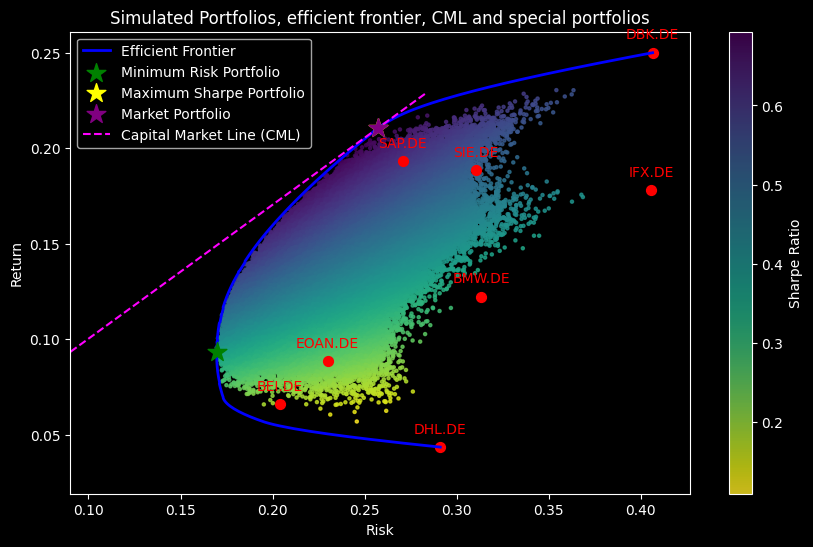

In [ ]:
# plotting of simulated portfolios/portfolio members, efficient frontier and special portfolios
plt.figure(figsize=(6, 4));
ptf.plot_portfolios(simulations, weights_record)    # Plot simulated portfolios
ptf.plot_constituents()                             # Plot constituents on the same figure
ptf.plot_efficient_frontier()                       # plot efficient frontier and special portfolios

# plotting
plt.xlabel('Risk')
plt.ylabel('Return')
plt.title('Simulated Portfolios, efficient frontier, CML and special portfolios')
plt.xlim(0.09)

plt.show()

In [ ]:
# printing paramters of members
df_res1 = ptf.data_constituents()
df_res1


 ** key data portfolio members **


,Returns,Risk,Sharpe (Orig.),Sharpe (incl. rfr)
Tickers,,,,
BEI.DE,0.066080,0.204016,0.323895,0.176848
BMW.DE,0.122296,0.313200,0.390471,0.294686
DBK.DE,0.250142,0.406355,0.615576,0.541748
DHL.DE,0.043421,0.291055,0.149185,0.046112
EOAN.DE,0.088337,0.229817,0.384380,0.253841
IFX.DE,0.178281,0.405386,0.439781,0.365777
SAP.DE,0.193358,0.270729,0.714214,0.603402
SIE.DE,0.188561,0.310276,0.607719,0.511031


In [ ]:
# printing parameters of special portfolios
dfy = ptf.data_portfolios()
dfy


 ** key data special portfolios **


,Risk,Return,Sharpe,Composition
Type,,,,
Minimum Risk Portfolio,0.169708,0.093032,0.371414,"[0.443, 0.015, 0.001, 0.053, 0.333, 0.0, 0.155..."
Maximum Sharpe Portfolio,0.257482,0.210838,0.702331,"[0.0, 0.0, 0.315, 0.0, 0.0, 0.0, 0.6, 0.085]"
